# Example Usage of Contours Processor

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1234)

%matplotlib inline

In [11]:
from contours_processor import ContourFileExtractor, ContourDataset

## Extract Dataset

* Create a Folder called data and extract the dicoms and contourfiles

In [12]:
# Load the link file to generate the mapping of Contours to Dicom files
def generate_contour_dicom_map(link_file):
    contour_dicom_pairs = pd.read_csv(link_file).to_dict(orient="rows")
    contour_dicom_map = {
        row["original_id"]: row["patient_id"] for row in contour_dicom_pairs
    }
    return contour_dicom_map

In [13]:
contour_dicom_map = generate_contour_dicom_map("data/final_data/link.csv")

In [14]:
contour_dicom_map

{'SC-HF-I-1': 'SCD0000101',
 'SC-HF-I-2': 'SCD0000201',
 'SC-HF-I-4': 'SCD0000301',
 'SC-HF-I-5': 'SCD0000401',
 'SC-HF-I-6': 'SCD0000501'}

## Load Contours

In [17]:
contour_top_folder = "data/final_data/contourfiles/"
dicom_top_folder = "data/final_data/dicoms/"

In [29]:
# Create a Contour Dataset Generator
contour_extractor = ContourFileExtractor(contour_top_folder, dicom_top_folder, 
                                         primary_contour="o-contours",
                                         contour_dicom_folder_map=contour_dicom_map,
                                         on_error_action="log",
                                         secondary_contours=["i-contours"])

contours_generator = contour_extractor.datasets_generator(shuffle=True)

# Use in Dataset
contours_dset = ContourDataset(contour_dicom_generator=contours_generator,
                              x_channels=["dicom", "o-contours"],
                              y_channels="i-contours",
                              include_sources=True)  # Include the Source files to visulalize incorrect data

In [30]:
for sources, X_data, y_data in contours_dset.generate_batch(batch_size=20, shuffle=True):
    # Model Training with Inputs and target for each batch
    
    # Apply the O-Contour Mask on the Image
    X_merged = (X_data[:, 0, :, :] * X_data[:, 1, :, :])
    break

Dataset failed validation data/final_data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0079-ocontour-manual.txt
Dataset failed validation data/final_data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0059-ocontour-manual.txt
Dataset failed validation data/final_data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0040-ocontour-manual.txt


## Method 1: Simple Threshold

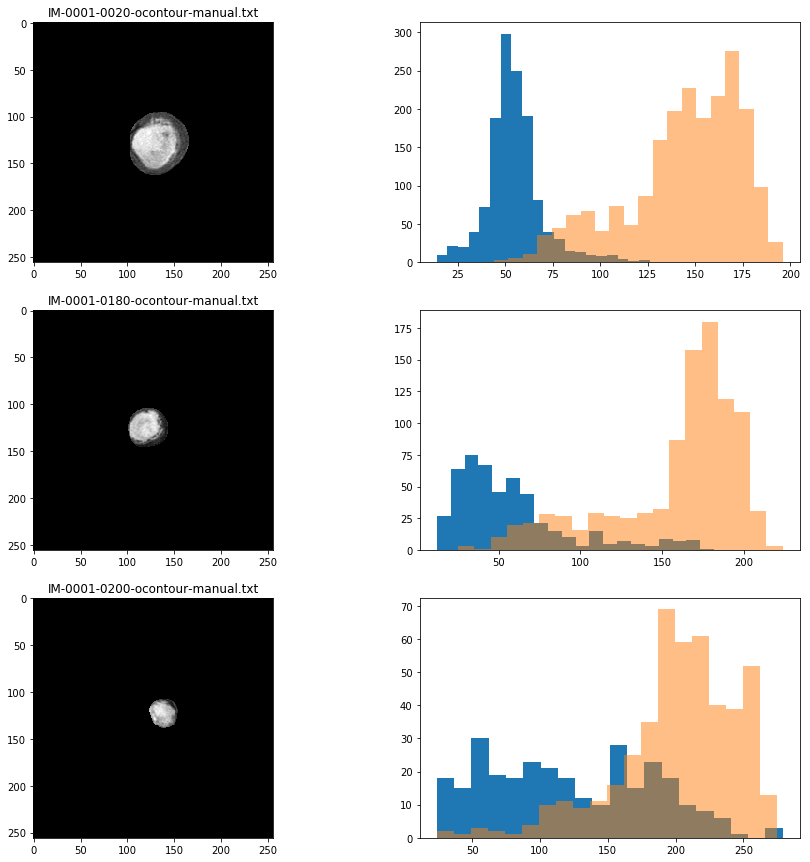

In [33]:
# Identify Threshold
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for idx, ax in enumerate(axes):

    ax[0].imshow(X_merged[idx], cmap=plt.cm.gray)
    filename = sources[idx]["o-contours"].split("/")[-1]
    ax[0].set_title(filename)
    
    # Plot the Histogram of I-Contour and O-Contour Pixels
    ax[1].hist(X_merged[idx][np.where((y_data[idx] == 0) & (X_merged[idx] > 0))], bins=20)
    ax[1].hist(X_merged[idx][np.where((y_data[idx] == 1) & (X_merged[idx] > 0))], bins=20, alpha=0.5);

In [49]:
## Define: Intersection Over Union
def get_overlap_region(x, y, threshold):
    x[np.where(x < 75)] = 0
    x[np.where(x > 0)] = 1

    intersection_pixels = ((x == 1) & (y == 1)).sum()
    union_pixels = ((x == 1) | (y == 1)).sum()
    
    return intersection_pixels / union_pixels

In [50]:
X_sample = X_merged[0].copy()
y_sample = y_data[0]

# Let's pick a threshold of 75 for the first image
overlap_region = get_overlap_region(X_sample, y_sample, threshold=75)

print("Region of Overlap: {}".format(overlap_region))

Region of Overlap: 0.9293302540415704


## As you can see it's really hard to identify the Threshold when the Pixel Intensity Historgram are not fully separable

We could take the two peaks in the histogram and try to find the valley in-between.  But that depends on the bins we use for the historgram, so not roubust

## Method 2: Adaptive Thresholding

We could use Adaptive Thresholding techique to find the threshold

In [34]:
from skimage import filters
from scipy import ndimage

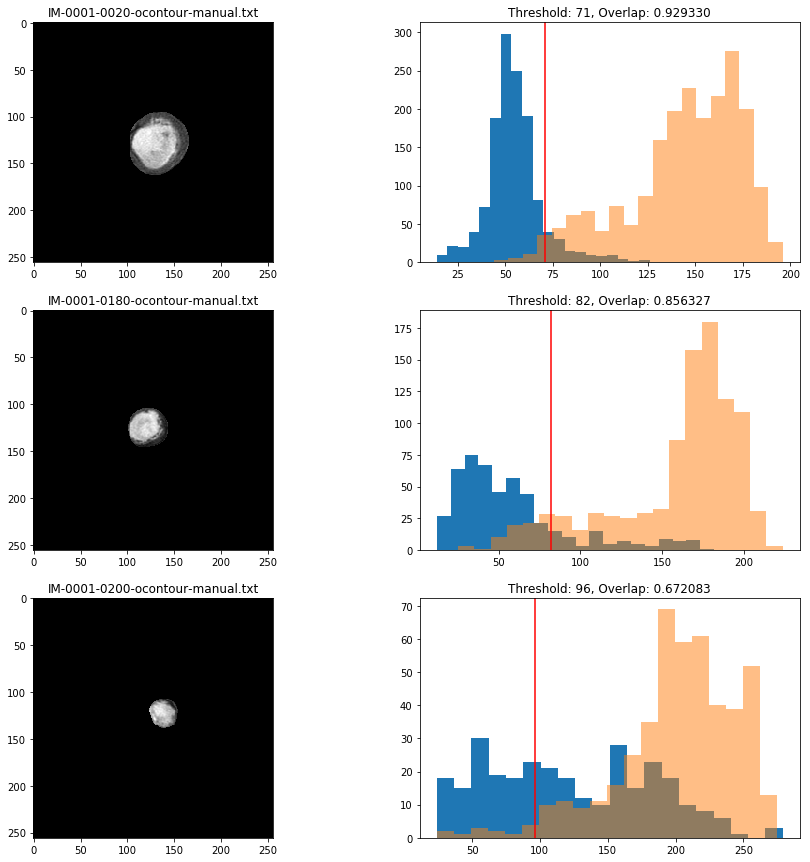

In [51]:
# Adaptive Threshold
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for idx, ax in enumerate(axes):

    ax[0].imshow(X_merged[idx], cmap=plt.cm.gray)
    filename = sources[idx]["o-contours"].split("/")[-1]
    ax[0].set_title(filename)
    
    # Plot the Histogram of I-Contour and O-Contour Pixels
    ax[1].hist(X_merged[idx][np.where((y_data[idx] == 0) & (X_merged[idx] > 0))], bins=20)
    ax[1].hist(X_merged[idx][np.where((y_data[idx] == 1) & (X_merged[idx] > 0))], bins=20, alpha=0.5);
    
    # Draw the Threshold Line
    threshold = filters.threshold_otsu(X_merged[idx])
    ax[1].axvline(x=threshold, color="r")

    # Get Overlap Region Metric
    overlap_region = get_overlap_region(X_merged[idx].copy(), y_data[idx], threshold=threshold)
    ax[1].set_title("Threshold: {}, Overlap: {:2f}".format(threshold, overlap_region))

### As you can see the intensity of first contours are seperated nicely, but there's lot of overlap of intensity pixels between the I-Contours and O-Contours of the third image that the overlap region metric drops considerably

## Method 3: Sobel filter

* https://en.wikipedia.org/wiki/Sobel_operator

In [64]:
x_sample = X_merged[0].copy()
y_sample = y_data[0]

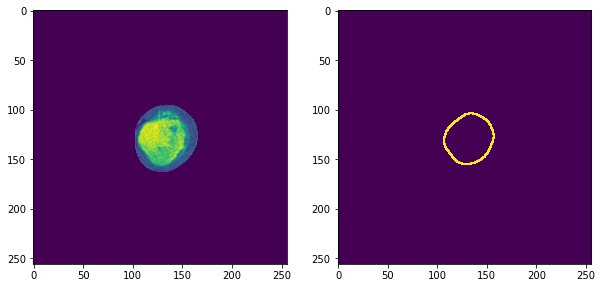

In [68]:
# Apply grey erosion to get the outline of outer contour
fig, ax  = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(x_sample)

im1 = ndimage.grey_erosion(y_sample, size=(5,5))
outer_contour = y_sample.astype(int) - im1.astype(int)
ax[1].imshow(y_sample.astype(int) - im1.astype(int))

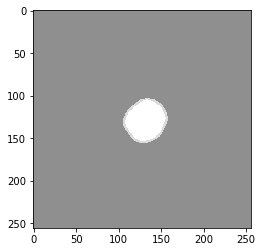

In [69]:
# Now Apply Sobel 
sx = ndimage.sobel(x_sample, axis=0, mode='constant')
sy = ndimage.sobel(x_sample, axis=1, mode='constant')
sob = np.hypot(sx, sy)
img = sob * im1

img2 = ndimage.binary_fill_holes(img)
plt.imshow(img2, alpha=0.2, cmap=plt.cm.gray)
plt.imshow(y_sample, alpha=0.3, cmap=plt.cm.gray);

In [79]:
# Fill the inner contourx_sobel_inner_contour = ndimage.binary_closing(img2, iterations=3)

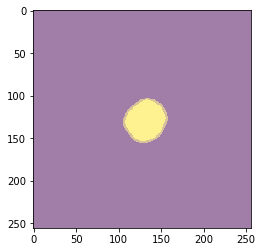

In [81]:
plt.imshow(x_sobel_inner_contour, alpha=0.3)
plt.imshow(y_sample, alpha=0.3)  # Inner Contour

# As you can see they match almost perfectly

In [86]:
## Identify the Region of Overlap
intersction_pixels = ((x_sobel_inner_contour == 1) & (y_sample == 1)).sum()
union_pixels = ((x_sobel_inner_contour == 1) | (y_sample == 1)).sum()

print("Region of overlap: {:.4f}".format(intersection_pixels / union_pixels))

Region of overlap: 0.9734


* This is much better than the Adaptive Threshold(0.92) or simple threshold techniques shown earlier

## Summary

Non-Deep Learning Image Analysis Techiques are very useful to get approximate I-Contours and should be used where applicable.

Edge Filter Convoltion techinques should also be explored.